# Ekarimi 2013 $ \rightarrow $

$$ B = B_0(\rho)\left[ \cos(q\theta+\beta), \sin(q\theta+\beta), 0\right]$$

## Multislice FFT:
\begin{align*}
\psi(z+\Delta z) &= P(x, y, \Delta z) \times \left[(T(x,y,z)+ T_p(x,y,z))\psi(z)\right]\\
&\approx \text{iFFT}\left\{ P(k_x, k_y, \Delta z)\; \text{FFT} \left[ (T+T_p)\psi(z) \right]\right\}
\end{align*}

## Interaction Terms

\begin{align*}
T(x,y,z_i) &= \exp \left( -\frac{ie}{\hbar} \int_{z_i}^{z_i+1} A_z(x,y,z)dz + \frac{ie}{\hbar v}\int_{z_i}^{z_i+1} V_E(x,y,z)dz + \frac{ie^2}{2m\hbar v}\int_{z_i}^{z_i+1} A_z^2(x,y,z)dz \right)\\
T_p(x,y,z_i) &= \begin{pmatrix} \cos(2\pi \frac{\Delta z}{\Lambda})& ie^{-i\alpha}\sin(2\pi \frac{\Delta z}{\Lambda})\\
ie^{i\alpha}\sin(2\pi \frac{\Delta z}{\Lambda}) & \cos(2\pi \frac{\Delta z}{\Lambda}) \end{pmatrix}\\
P(x,y,\Delta z) &= \frac{1}{i\lambda\Delta z}\exp\left[ i\frac{\pi}{\lambda \Delta z} (x^2 + y^2) \right]\\
P(k_x, k_y, \Delta z) &= \exp\left[ i\pi \lambda \Delta z (k_x^2 + k_y^2)\right]
\end{align*}

$$ \psi = N(\frac{r}{\omega})^l\exp(-\frac{r^2}{\omega^2})\exp(il\phi)*\frac{1}{\sqrt{2}}(\mid\uparrow\rangle +  \mid\downarrow\rangle)$$

$ N = \sqrt{\frac{2k+1}{\pi l! \omega^2}} $

$ \Lambda = \frac{2\pi\hbar^2k_0}{m^*\frac{1}{2}g\mu_BB_0} $

$ \omega' = \omega\sqrt{l/2} $

In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [380]:
def main(Nz):
  # Simulation parameters
  N     = 512   # Spatial resolution
  z     = 0     # current z of the simulation
  zEnd  = 0.05  # z at which simulation ends
  dz    = 0.0025  # zstep
  zOut  = 0.0025  # draw frequency
  hbar = 10e-34
  m = 1e-30  # kilograms
  e = 1.6e-19  # coulombs
  c = 3e8  # meters/seconds

  # Domain
  L = 100e-6
  xlin = np.linspace(-L, L, num=N+1)
  xlin = xlin[0:N]
  xx, yy = np.meshgrid(xlin, xlin)
  theta = np.linspace(0, 2*np.pi, num=N+1)
  theta = theta[0:N]
  mu_B = e*hbar/(2*m)
  g = 2

  # Initial Condition
  B_0 = 1e-3  # tesla
  epsilon = 1.6e-14  # joules
  omegap = 10e-6  # meters
  l = 1  # radial number
  omega = omegap/np.sqrt(l/2)  # ray's width
  mstar = m / (1 + (epsilon/(m*c**2)))**2  # relativistic mass
  lam = hbar/(2*np.pi)*(2*m*epsilon*(1+(epsilon/(2*m*c**2))))**(-1/2)  # wavelength
  v = c * (1 - 1/(1 + (epsilon/(m*c**2)))**2)**(1/2)  # velocity
  k_0 = 1/hbar * (2*m*epsilon*(1+epsilon/(2*m*c**2)))**(1/2)
  Lam = (2*np.pi*hbar**2*k_0)/(mstar*(1/2)*g*mu_B*B_0)
  No = np.sqrt((2**(l+1))/(np.pi*np.math.factorial(l)*omega**2))
  theta = np.arctan(yy/xx)
  theta[((xx==0) * (yy==0))] = np.pi/2
  q = -1
  beta = 0
  alpha = q*theta+beta
  psi = No*((np.sqrt(xx**2+yy**2))/omega)**l*np.exp(-(xx**2+yy**2)/omega**2)*np.exp(1j*l*(theta))
  psi /= np.sqrt(np.mean(np.absolute(psi)**2))
  u, d = psi, psi
  Psi = np.array([psi, 0*psi])

  # Fourier Space Variables
  klin = 2.0 * np.pi / L * np.arange(-N/2, N/2)
  kx, ky = np.meshgrid(klin, klin)
  kx = np.fft.ifftshift(kx)
  ky = np.fft.ifftshift(ky)
  kSq = kx**2 + ky**2

  # number of slices
  #Nz = int(np.ceil(zEnd/dz))

  T = np.exp((1j*e**2)/(2*m*hbar*v) * ((yy**2*np.cos(alpha)**2 + xx**2*np.sin(alpha)**2 - 2*xx*yy*np.cos(alpha)*np.sin(alpha))*dz))
  T_p = [[np.cos(2*np.pi*dz/Lam), 1j*np.exp(-1j*alpha)*np.sin(2*np.pi*dz/Lam)],
        [1j*np.exp(1j*alpha)*np.sin(2*np.pi*dz/Lam), np.cos(2*np.pi*dz/Lam)]]
  P = np.exp(1j*np.pi*lam*dz*kSq)

  for i in range(Nz):
    # plot in real time
    # prep figure
    fig = plt.figure(figsize=(9,6), dpi=80)
    grid = plt.GridSpec(1, 2, wspace=0.0, hspace=0.0)
    ax1 = plt.subplot(grid[0,0])
    ax2 = plt.subplot(grid[0,1])
    outputCount = 1

    plotRealTime=True
    plotThisTurn = False
    if z + dz > outputCount*zOut:
      plotThisTurn = True
    if (plotRealTime and plotThisTurn) or (i == Nz-1) or z==0:
      
      plt.sca(ax1)
      plt.cla()
      
      plt.contourf((np.abs(Psi[0])**2), 30, cmap = 'inferno')
      ax1.get_xaxis().set_visible(False)
      ax1.get_yaxis().set_visible(False)	
      ax1.set_aspect('equal')	
      
      plt.sca(ax2)
      plt.cla()
      plt.contourf((np.abs(Psi[1])**2), 30, cmap = 'inferno')
      ax2.get_xaxis().set_visible(False)
      ax2.get_yaxis().set_visible(False)	
      ax2.set_aspect('equal')	
    
    
      plt.pause(0.001)
      outputCount += 1

    # 1/2 kick
    Psi = T * Psi
    Psi = np.array([T_p[0][0]*Psi[0] + T_p[0][1]*Psi[1], T_p[1][0]*Psi[0] + T_p[1][1]*Psi[1]])

    # drift
    psihat = (np.array([np.fft.fftn(Psi[0]), np.fft.fftn(Psi[1])]))
    psihat = P * psihat
    Psi = (np.array([np.fft.ifftn(psihat[0]), np.fft.ifftn(psihat[1])]))

    # 1/2 kick
    Psi = T * Psi
    Psi = np.array([T_p[0][0]*Psi[0] + T_p[0][1]*Psi[1], T_p[1][0]*Psi[0] + T_p[1][1]*Psi[1]])

    # update z
    z += dz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


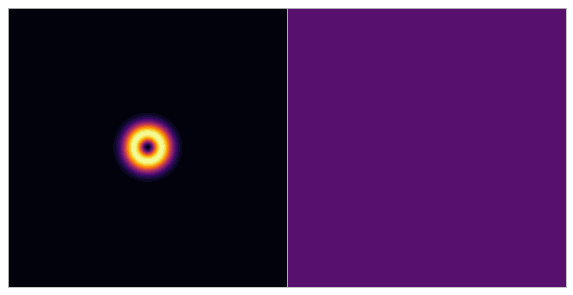

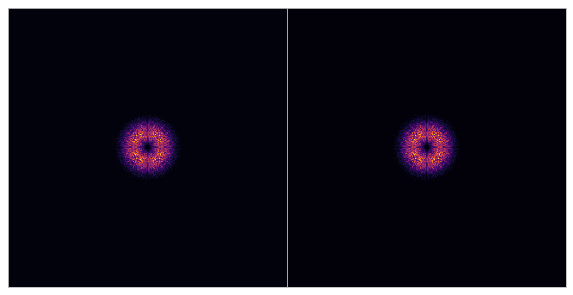

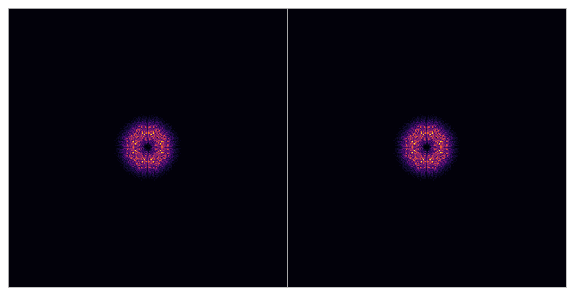

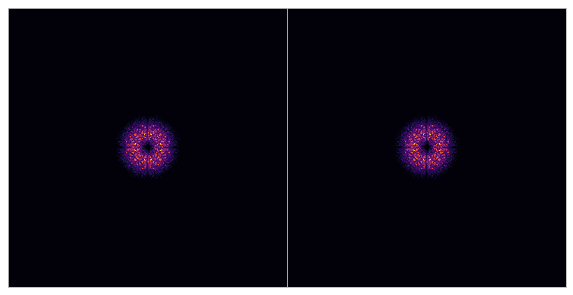

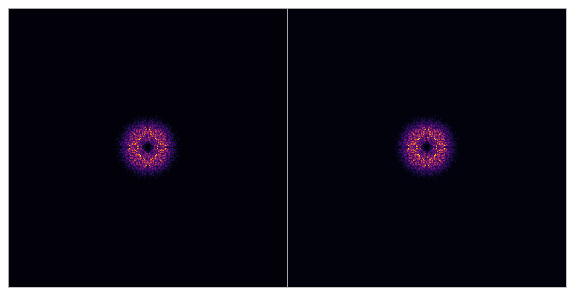

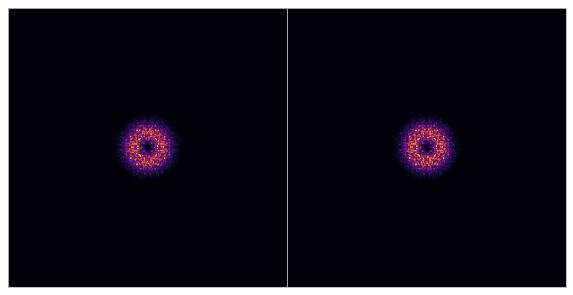

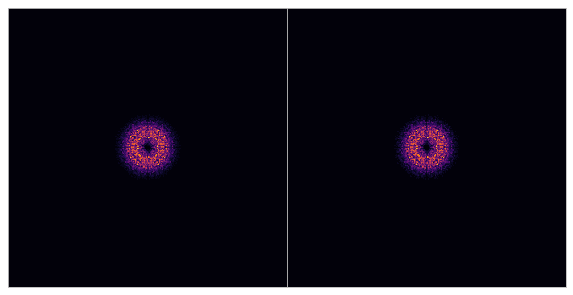

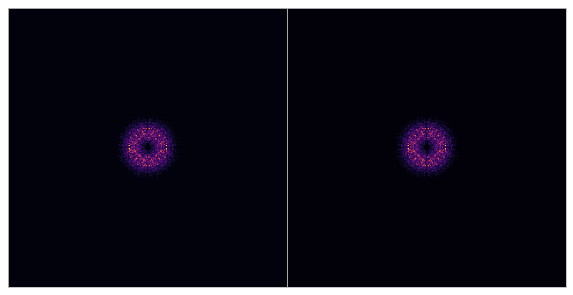

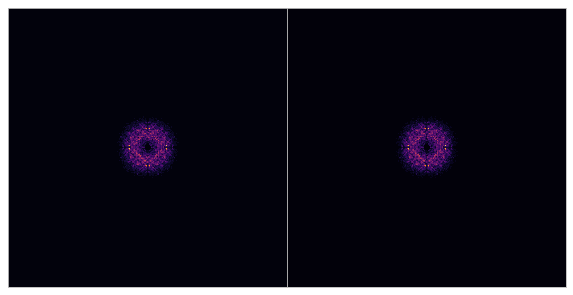

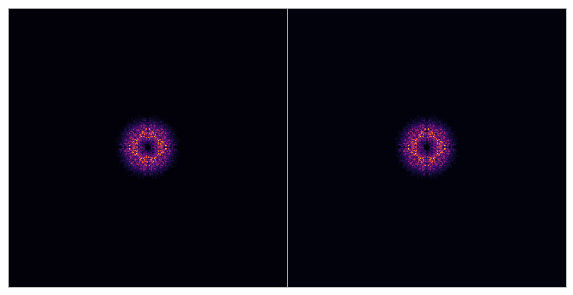

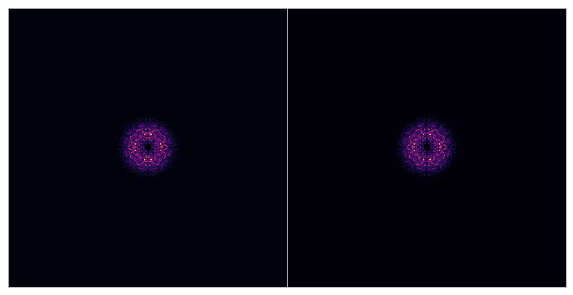

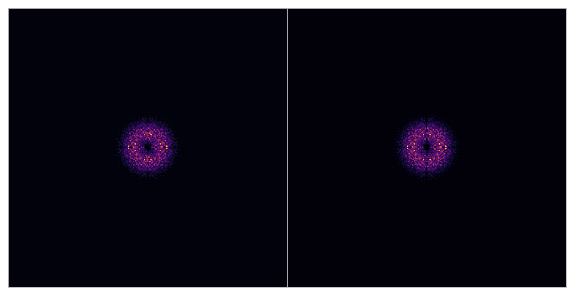

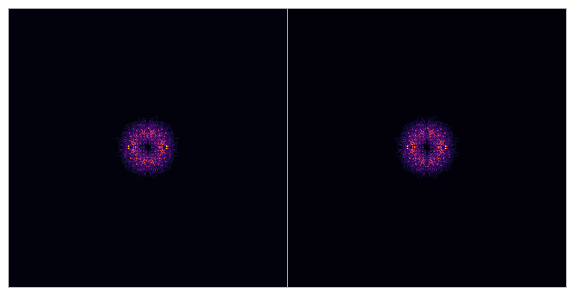

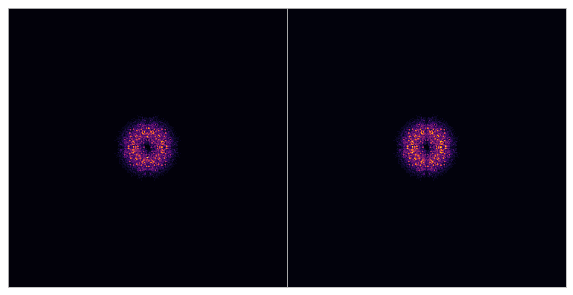

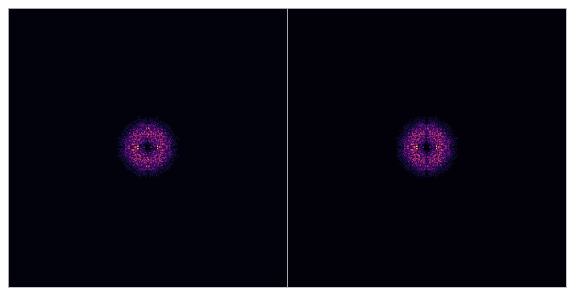

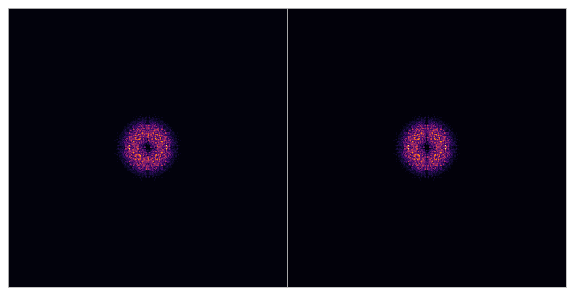

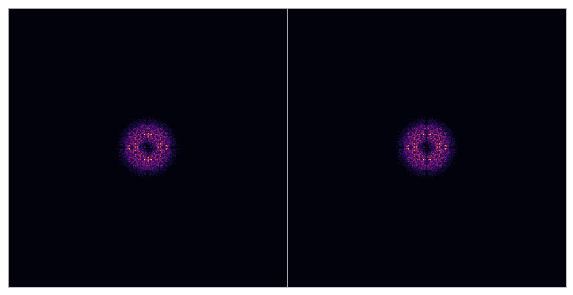

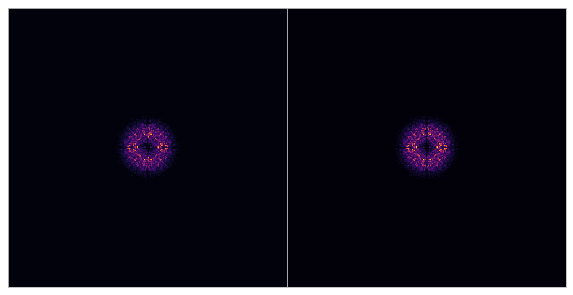

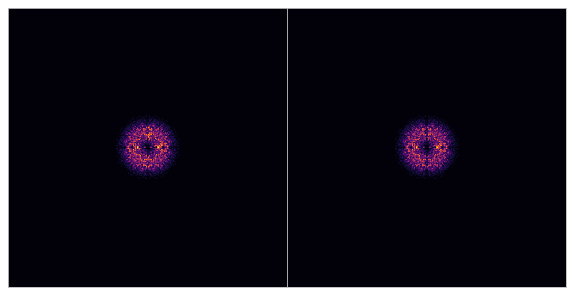

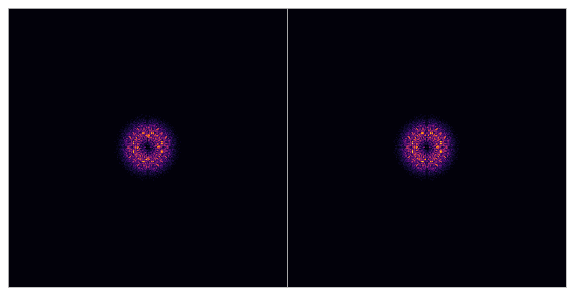

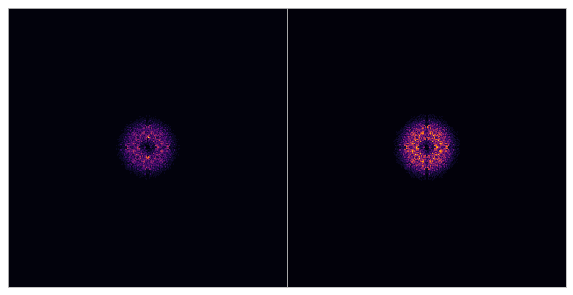

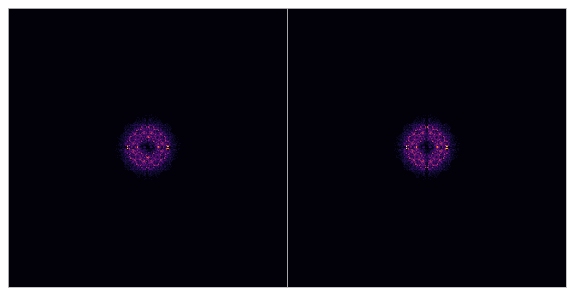

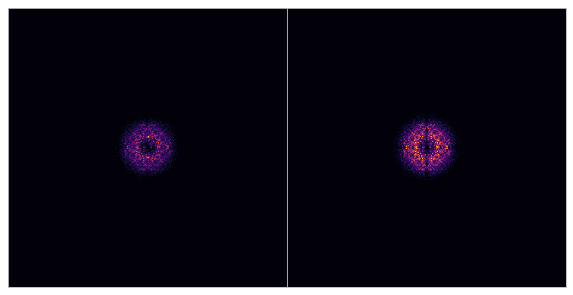

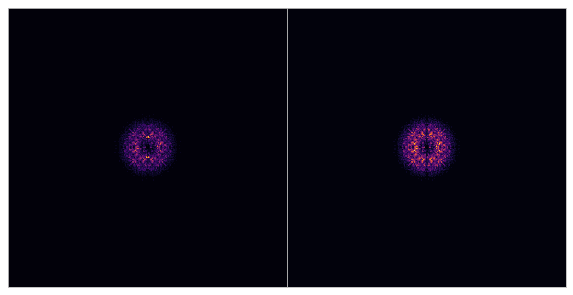

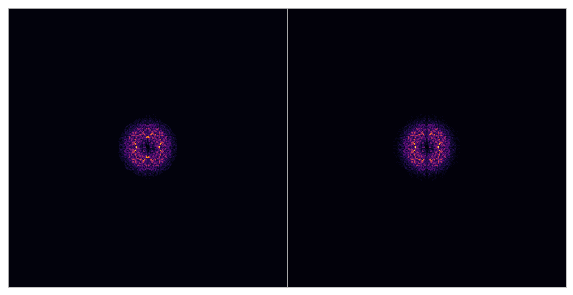

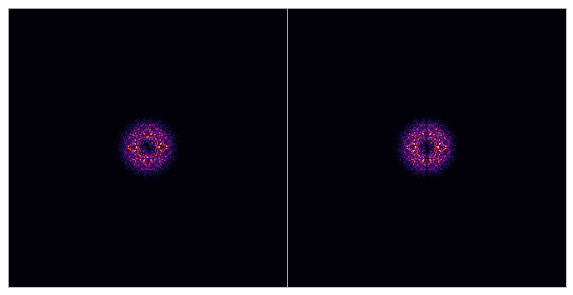

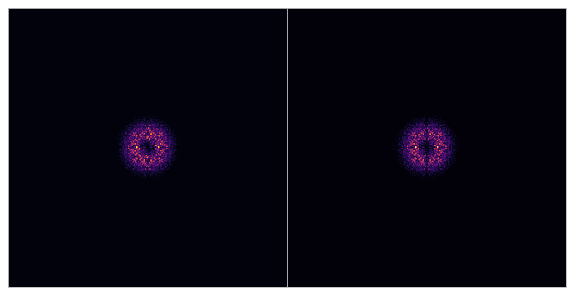

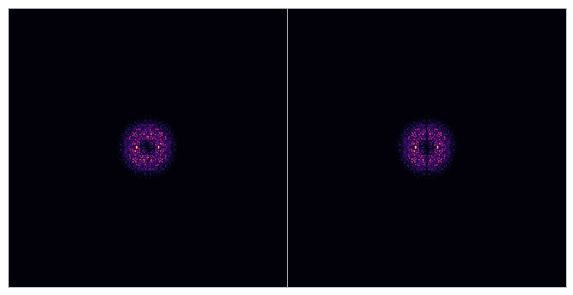

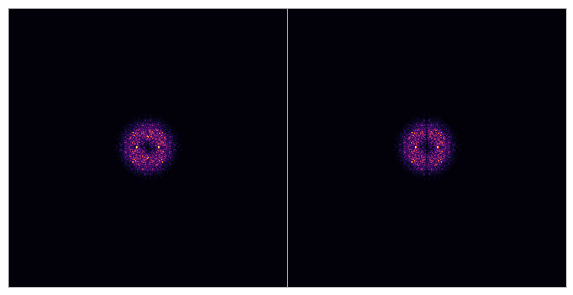

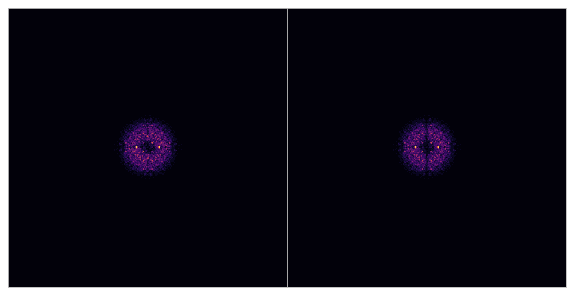

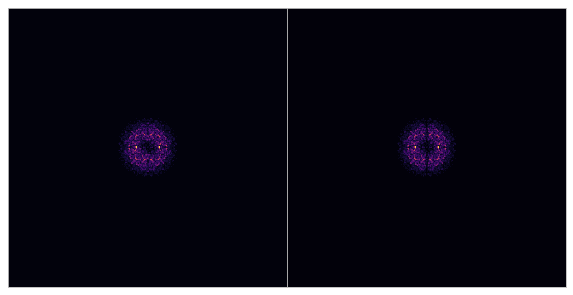

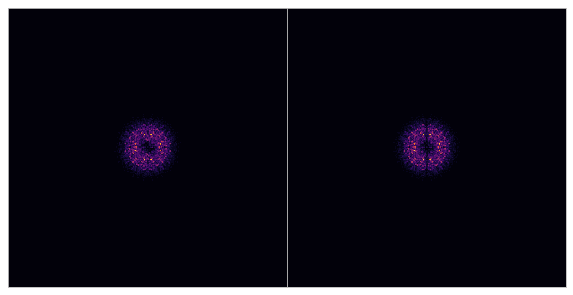

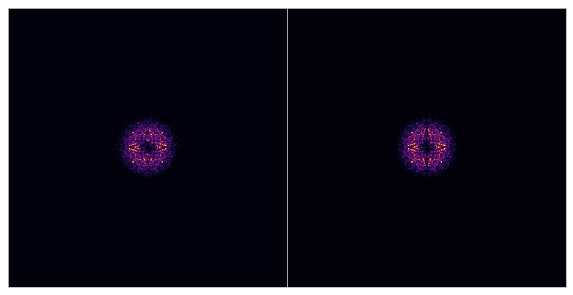

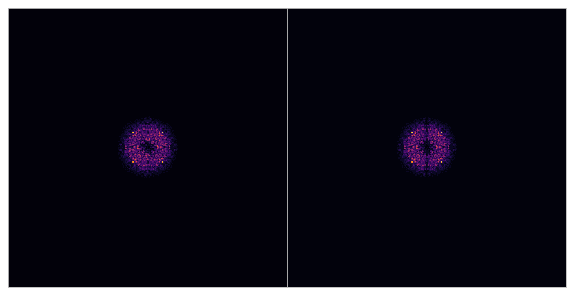

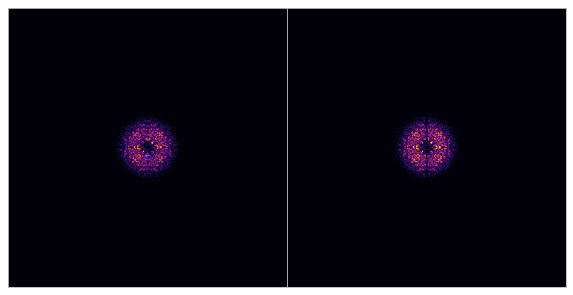

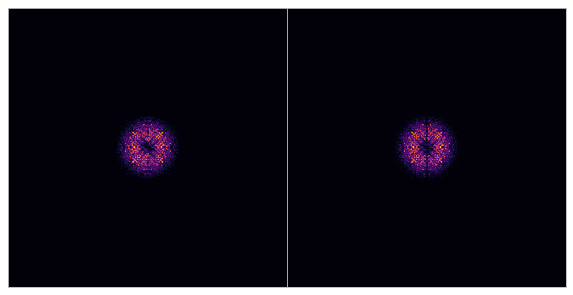

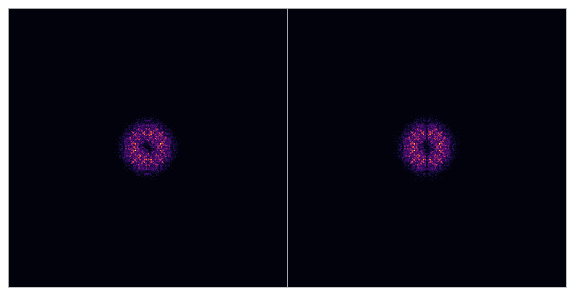

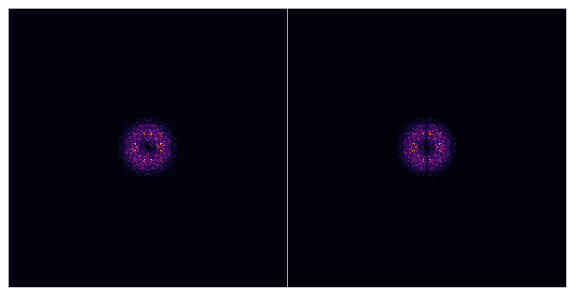

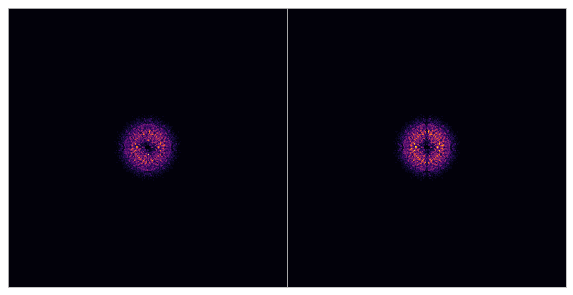

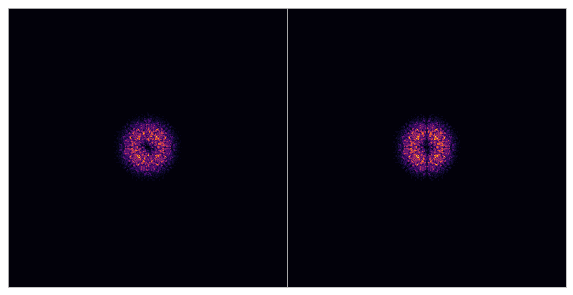

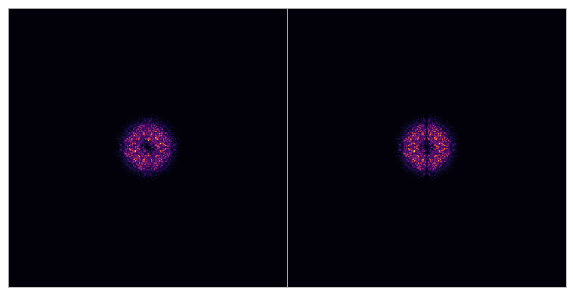

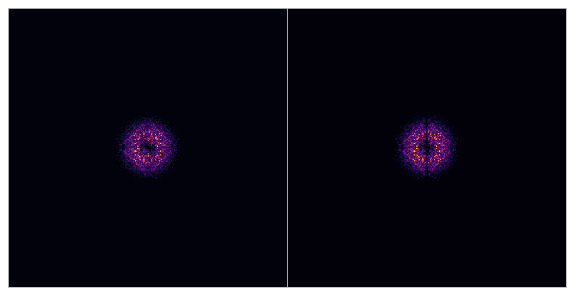

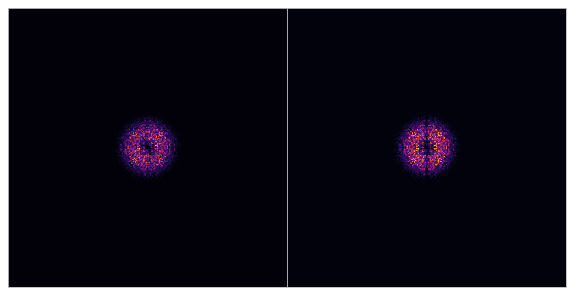

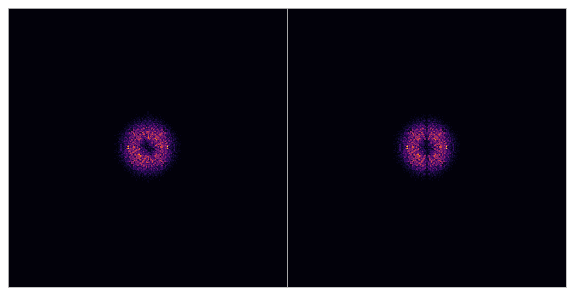

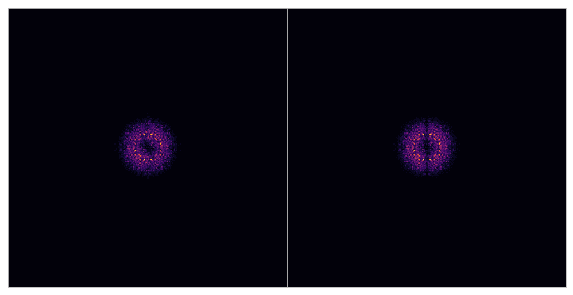

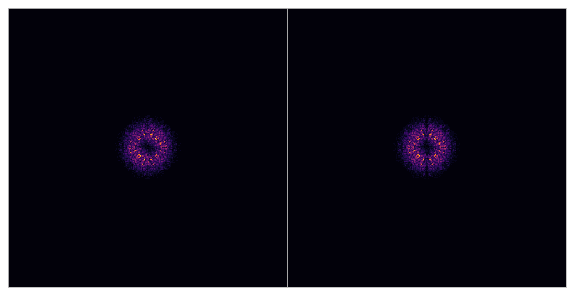

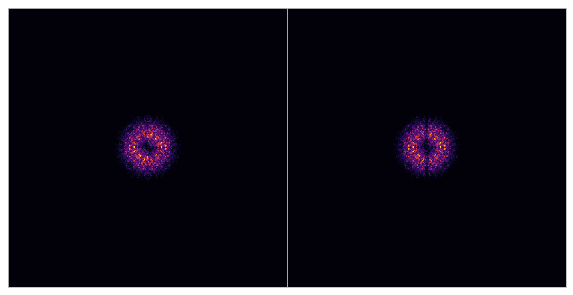

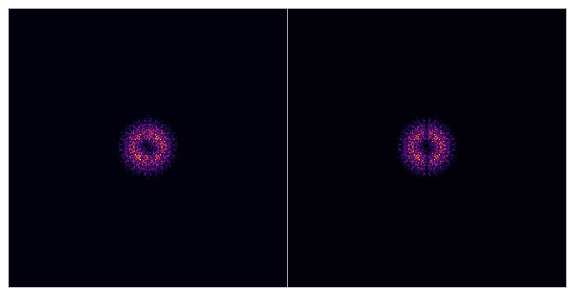

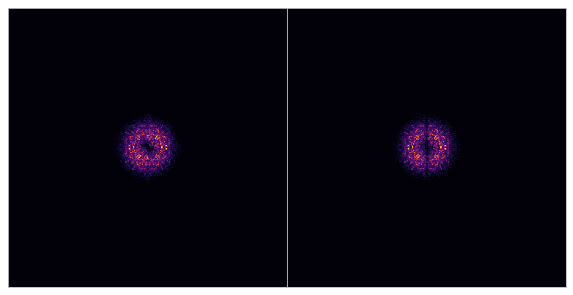

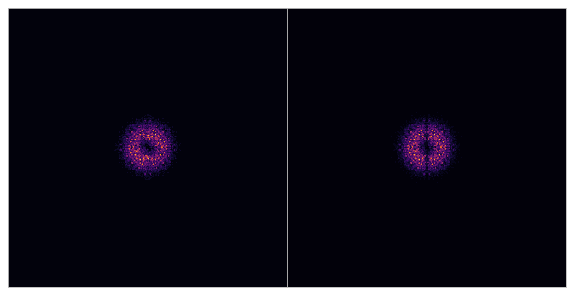

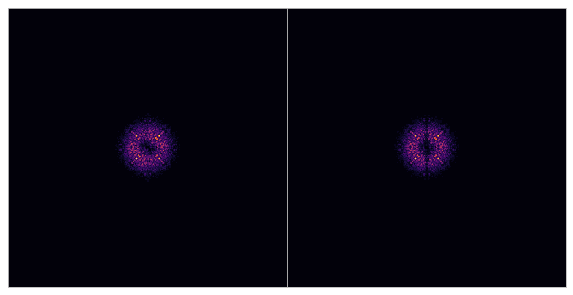

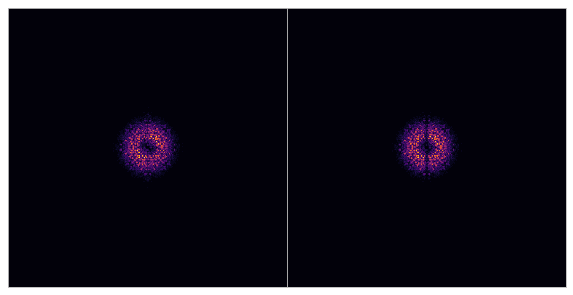

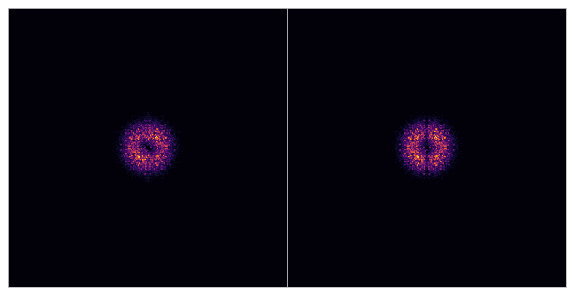

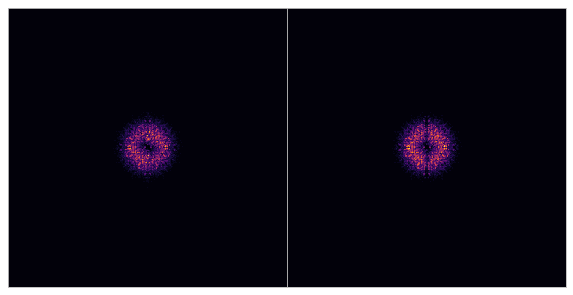

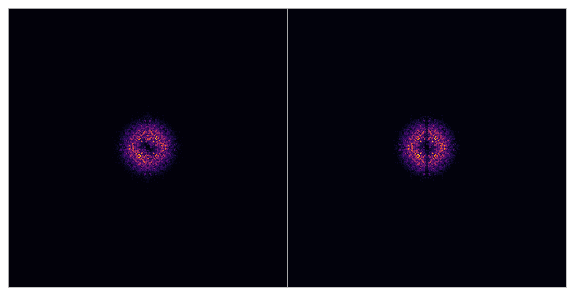

In [382]:
main(55)